# **Data import**

In [468]:
import pandas as pd
import requests
from io import StringIO
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

resp = requests.get('https://k-copart-car-price-prediction.s3.eu-north-1.amazonaws.com/data.csv')

if resp.status_code == 200:
  data = resp.text
else:
  print("can't fetch data")
  exit()

df = pd.read_csv(StringIO(data))

# **Data cleanup and datatype conversions**

Drop unused columns:

In [469]:
df = df[df.Final_bid != 0]
df = df.drop(['Sold', 'Make', 'Engine', 'Special Note', 'Interior', 'Make', 'Manufactured In', 'Exterior'], axis=1)

Remove Duplicates:

In [470]:
df = df.drop_duplicates()
df[df.duplicated()]
df.shape

(791, 25)

Clean the data:

In [471]:
df = df[df.Odometer_km != 'unknown)']
df = df[df.Cylinders != 'All']
df = df[df.Eng_L != 'U']

Data types conversions:

In [472]:
df.Model = df.Model.str.title()

df['Auction_date'] = pd.to_datetime(df['Auction_date'])

to_num = ['Year', 'Final_bid', 'Cylinders', 'Odometer_km', 'Actual_cash_value', 'Estimated_repair_cost', 'Eng_L', 'Eng_HP']

for _ in to_num:
  df[_] = pd.to_numeric(df[_])

Cleanup Actual cash value == 0 and Estimated repair cost

# **Dataset stats**

In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 0 to 803
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Final_bid              730 non-null    int64         
 1   Seller                 730 non-null    object        
 2   Auction_date           730 non-null    datetime64[ns]
 3   Year                   730 non-null    int64         
 4   vin                    730 non-null    object        
 5   Loss                   730 non-null    object        
 6   Primary damage         730 non-null    object        
 7   Secondary damage       729 non-null    object        
 8   Start code             730 non-null    object        
 9   Key                    730 non-null    object        
 10  Body Style             316 non-null    object        
 11  Vehicle Class          160 non-null    object        
 12  Model                  730 non-null    object        
 13  Fuel Type 

In [474]:
df.describe()

,Final_bid,Auction_date,Year,Cylinders,Odometer_km,Actual_cash_value,Estimated_repair_cost,Eng_L,Eng_HP
count,730.00,730,730.00,185.00,730.00,730.00,730.00,729.00,185.00
mean,"6,254.85",2024-06-02 09:10:21.369862912,"2,013.96",4.65,"207,696.73","14,274.96","7,736.18",2.66,188.55
min,2.00,2024-05-30 00:00:00,"2,000.00",4.00,177.00,0.00,0.00,1.50,73.00
25%,"1,550.00",2024-06-01 06:00:00,"2,009.00",4.00,"92,078.50","3,624.25",0.00,1.80,132.00
50%,"3,462.50",2024-06-03 00:00:00,"2,014.00",4.00,"197,739.00","11,013.00",0.00,2.50,176.00
75%,"8,687.50",2024-06-03 00:00:00,"2,019.00",6.00,"291,468.25","21,856.25","14,039.75",3.50,240.00
max,"33,075.00",2024-06-05 00:00:00,"2,024.00",8.00,"788,968.00","67,208.00","56,450.00",5.70,382.00
std,"6,683.66",NaN,6.27,1.15,"138,121.54","13,316.26","10,323.91",0.91,70.05


# **Data analysis**




## Actual cash value and Estimated repair cost

In [475]:
print(f"[ACV = 0]: {(df['Actual_cash_value'] == 0).sum()}")
print(f"[ERC = 0]: {(df['Estimated_repair_cost'] == 0).sum()}")

[ACV = 0]: 150
[ERC = 0]: 372


Since for most cases there's no good explanation why Actual_cash_value = 0, it makes sense to clean up these rows so that other predictions will be more accurate.
Makes sense to keep Estimated repair cost = 0 since it seem to have an explanation (e.g. when it's not clear what needs to be repaired)

In [476]:
df = df[df['Actual_cash_value'] != 0]
print(f"[ACV = 0]: {(df['Actual_cash_value'] == 0).sum()}")
print(f"[ERC = 0]: {(df['Estimated_repair_cost'] == 0).sum()}")
print(df.shape)

[ACV = 0]: 0
[ERC = 0]: 222
(580, 25)


Let's take a look on Actual cash value vs bid price:

In [477]:
sctr = px.scatter(df, x = 'Actual_cash_value', y = "Final_bid", title = "Actual cash value vs bid price", hover_name = df.index)

sctr.update_layout(xaxis_title = "Actual cash value", yaxis_title= "Final bid")

sctr.show()

In [478]:
sctr = px.scatter(df, y = 'Final_bid', x = "Estimated_repair_cost", title = "Estimated repair cost", hover_name = df.index)

sctr.update_layout(yaxis_title = "Final bid", xaxis_title= "Estimated repair cost")

sctr.show()

Actual cash value chart looks healthy and show strong correlation. Although, some additional data for cars above 20k would make the predictions more accurate

Estimated repair cost column has many zeros which will affect the prediction. Cleanup of those values to be considered

## Models distribution

Clean and unify models:

In [479]:
df.loc[df['Model'] == '4Runner Se', 'Model'] = '4Runner'
df.loc[df['Model'] == 'Camry Sola', 'Model'] = 'Camry'
df.loc[df['Model'] == 'Grand Highlander', 'Model'] = 'Highlander'
df.loc[df['Model'] == 'Corolla Cr', 'Model'] = 'Corolla'
df.loc[df['Model'] == 'Camry Hybrid', 'Model'] = 'Camry'
df.loc[df['Model'] == 'Prius C', 'Model'] = 'Prius'
df.loc[df['Model'] == 'Avalon Hybrid', 'Model'] = 'Avalon'
df.loc[df['Model'] == 'Corolla (U.S.)', 'Model'] = 'Corolla'
df.loc[df['Model'] == 'Prius Nigh', 'Model'] = 'Prius'

df = df[df.Model != 'All Models']

In [480]:
models_df = df.groupby('Model', as_index=False).agg({'Final_bid': pd.Series.mean,
                         'Auction_date': pd.Series.count,
                        'Actual_cash_value': pd.Series.mean})

models_df = models_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

models_df

,Model,Avg_final_bid,Count,Avg_actual_cash_value
3,Camry,"4,115.44",124,"12,614.69"
4,Corolla,"4,027.63",106,"12,253.50"
13,Rav4,"8,865.07",68,"21,372.96"
12,Prius,"4,012.15",68,"13,285.12"
17,Tacoma,"11,156.77",48,"29,523.00"
9,Highlander,"12,858.59",41,"24,966.10"
0,4Runner,"13,320.37",27,"29,447.70"
18,Tundra,"14,932.86",21,"32,659.38"
20,Yaris,"2,297.50",10,"9,039.30"
14,Scion,"1,033.33",9,"7,244.33"


Drop models with very low count (until we have more data for them)

In [481]:
models_df = models_df[models_df.Count >= 10]

df = df[df['Model'].isin(models_df.Model)]
models_df

,Model,Avg_final_bid,Count,Avg_actual_cash_value
3,Camry,"4,115.44",124,"12,614.69"
4,Corolla,"4,027.63",106,"12,253.50"
13,Rav4,"8,865.07",68,"21,372.96"
12,Prius,"4,012.15",68,"13,285.12"
17,Tacoma,"11,156.77",48,"29,523.00"
9,Highlander,"12,858.59",41,"24,966.10"
0,4Runner,"13,320.37",27,"29,447.70"
18,Tundra,"14,932.86",21,"32,659.38"
20,Yaris,"2,297.50",10,"9,039.30"


In [482]:
bar = px.bar(x = models_df.Model,
             y = models_df.Count,
             title='Distribution of models in dataset',
             hover_name=models_df.Model,
             color=models_df.Avg_final_bid,
             color_continuous_scale='Agsunset')

bar.update_layout(xaxis_title='Model',
yaxis_title='Amount of cars in the dataset',
coloraxis_showscale=False)

bar.show()

Range of bids by model:

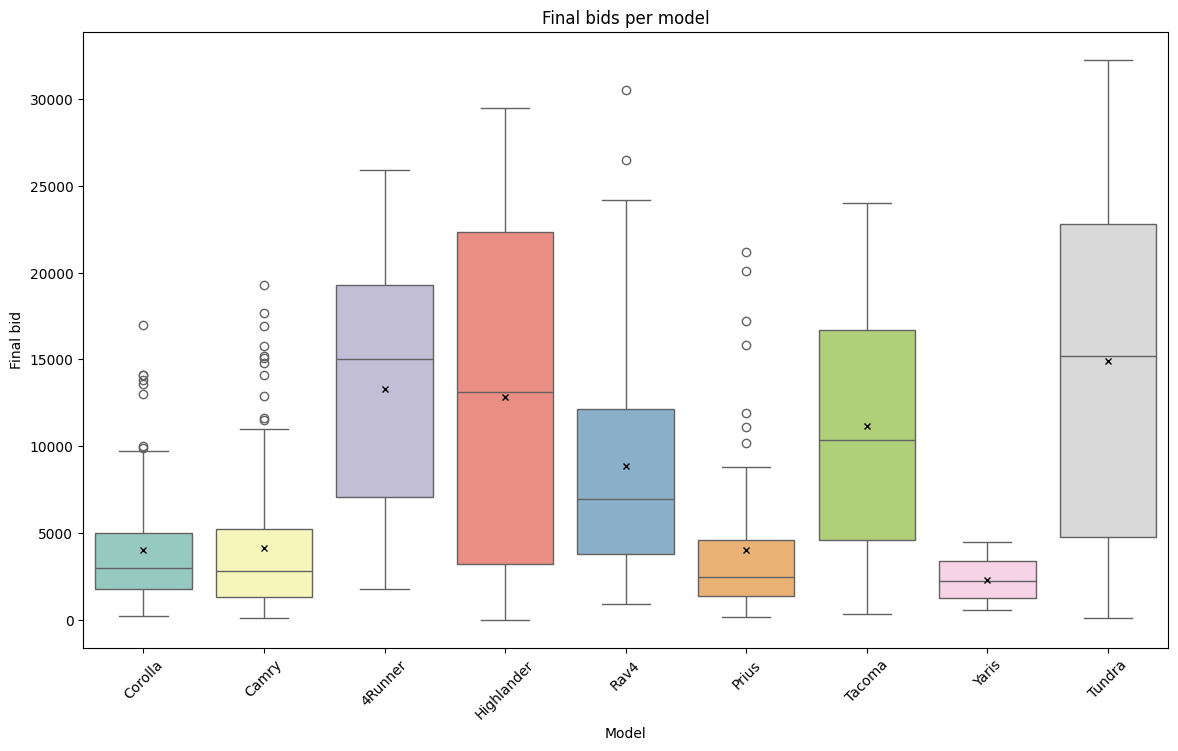

In [483]:
# box = px.box(df,
#              y='Model',
#              x='Final_bid',
#             #  notched=True,
#             #  points='all',
#              title='Final bids per model')

# # box.update_layout(yaxis=dict(type='log'))

# box.show()


plt.figure(figsize=(14, 8))

box = sns.boxplot(
    data=df,
    x='Model',
    y='Final_bid',
    palette='Set3',
    showmeans=True,
    meanprops={"marker":"x", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}
)


plt.title('Final bids per model', fontsize=12)
plt.xlabel('Model', fontsize=10)
plt.ylabel('Final bid', fontsize=10)
plt.xticks(rotation=45)
# plt.grid(True)

plt.show()

## Distribution by Model Series

In [484]:
series_df = df.groupby('Series', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

series_df = series_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count', 'Avg_final_bid'], ascending=False)

series_df

,Series,Avg_final_bid,Count,Avg_actual_cash_value
12,LE,"3,928.49",43,"11,736.74"
44,XLE,"9,257.35",17,"22,077.65"
25,SE,"4,523.33",15,"12,198.33"
41,TWO,"2,495.00",5,"8,331.20"
18,LIMITED,"15,125.00",4,"33,141.25"
37,THREE,"1,450.00",4,"7,331.00"
35,SR5 V6,"10,000.00",3,"27,468.67"
49,XLE V6,"2,266.67",3,"7,884.33"
9,II,"2,075.00",3,"6,036.67"
1,CE,575.00,3,941.67


Data in this column seems a bit non-systematic. Also there's too many missingdata to make sense of it. Will not be used for prediction

## Distribution by damage

In [485]:
# merging since it looks like the same thing with different names
df.loc[df['Primary damage'] == 'Flood', 'Primary damage'] = 'Water / flood'

In [486]:
damage_df = df.groupby('Primary damage', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

damage_df = damage_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count', 'Avg_final_bid'], ascending=False)

damage_df

,Primary damage,Avg_final_bid,Count,Avg_actual_cash_value
4,Front end,"6,487.21",223,"17,750.49"
14,Rear,"7,782.88",73,"18,235.99"
21,Side,"7,959.42",38,"19,678.34"
0,All over,"7,323.29",35,"22,429.06"
3,Front & rear,"6,475.00",17,"16,386.06"
9,Left side,"3,983.93",14,"13,085.86"
24,Unknown,"1,978.85",13,"5,211.46"
10,Mechanical,"1,120.46",13,"5,624.85"
12,Normal wear,"4,806.82",11,"12,435.45"
18,Right side,"11,222.50",10,"26,348.30"


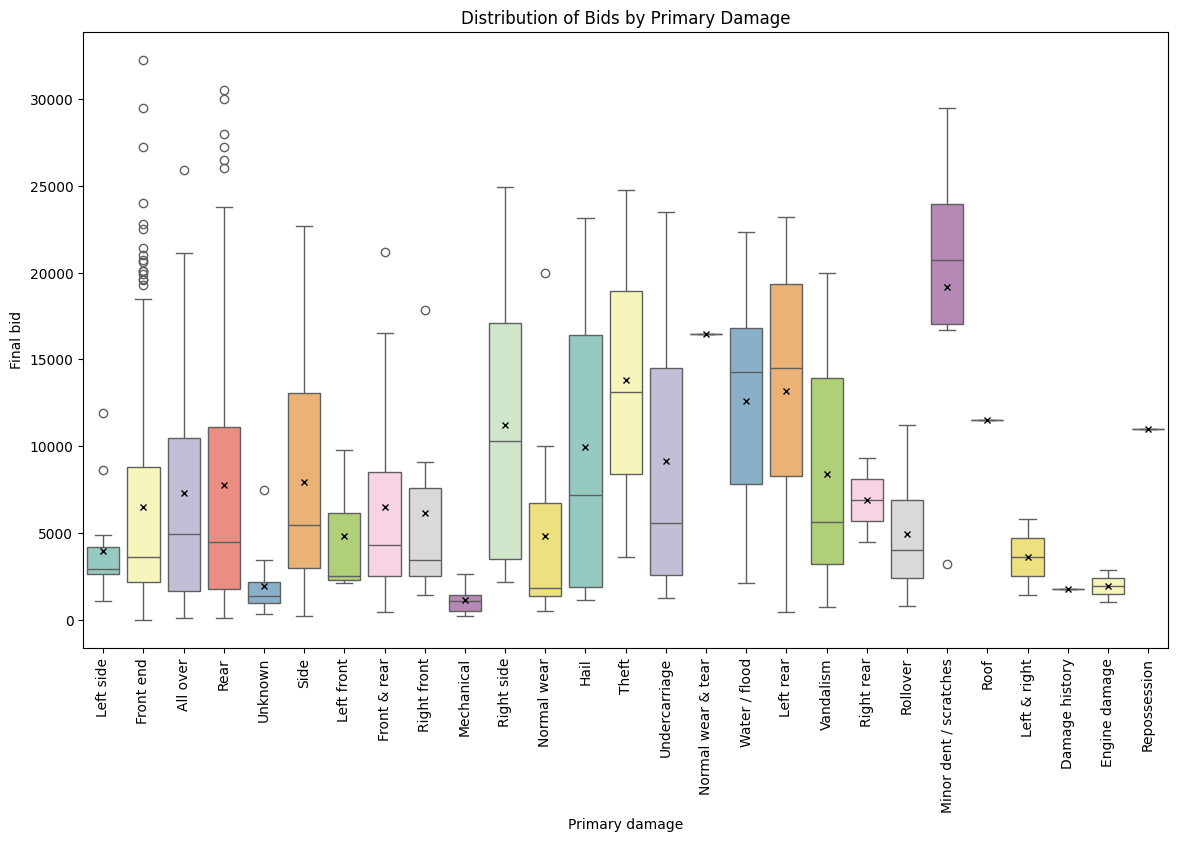

In [487]:
plt.figure(figsize=(14, 8))

box = sns.boxplot(
    data=df,
    x='Primary damage',
    y='Final_bid',
    palette='Set3',
    showmeans=True,
    meanprops={"marker":"x", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}
)


plt.title('Distribution of Bids by Primary Damage', fontsize=12)
plt.xlabel('Primary damage', fontsize=10)
plt.ylabel('Final bid', fontsize=10)
plt.xticks(rotation=90)
# plt.grid(True)

plt.show()

It's very tempting to merge these values:
* "Left side", "Right side", and "Side"
* "Left rear", "Right rear", and "Rear"
* "Left front", "Right front", and "Front end"

However it turns out that there's a big difference in statistical price values between them. Probably it has smth to do with the fact that people in US/Canada are driving on the right side of the road and thus damages of the left side are generally more severe, thus prices for those bids are lower.

Possible explanation: damage from the car that swings from the opposite lane would be more severe compared to collision with cars that go in the same direction

<h3>Secondary damage:</h3>

In [488]:
sec_damage_df = df.groupby('Secondary damage', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

sec_damage_df = sec_damage_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

sec_damage_df

,Secondary damage,Avg_final_bid,Count,Avg_actual_cash_value
0,-,"7,270.03",287,"18,331.61"
23,Side,"6,985.00",40,"19,886.65"
6,Front end,"5,250.00",30,"15,982.50"
27,Unknown,"7,130.17",29,"15,957.79"
14,Minor dent / scratches,"6,653.54",26,"14,714.42"
17,Rear,"8,630.04",25,"23,839.84"
20,Right side,"5,595.45",11,"15,784.09"
26,Undercarriage,"5,525.00",8,"16,628.75"
24,Suspension,"9,803.12",8,"20,735.38"
13,Mechanical,"3,007.17",6,"10,064.33"


In [489]:
burst_df = df.groupby(by=['Primary damage', 'Secondary damage'], as_index=False).agg({'Final_bid': pd.Series.count})


burst_df = burst_df.rename(columns = {'Final_bid' : 'Count'})
burst_df = burst_df.sort_values('Count', ascending=False)



burst = px.sunburst(burst_df,
                    path=['Primary damage', 'Secondary damage'],
                    values='Count',
                    title='Damage types',
                   )

burst.show()

**<h2>Conclusion regarding damage:</h2>**

* Front end is amazingly popular damage
* Cars with Front end damage are cheaper than with Rear damage
* Cars with Left side damage are cheaper (and twice more frequent!) than cars with Right side damage

> Cars with "All over" and "Rollover" damages are rather expensive for unclear reason  [To be investigated]




## Distribution by Sellers

In [490]:
sellers_df = df.groupby('Seller', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

sellers_df = sellers_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

sellers_df = sellers_df[sellers_df.Count > 5]
sellers_df

,Seller,Avg_final_bid,Count,Avg_actual_cash_value
15,Insurance company,"6,011.05",133,"17,331.39"
22,Non-insurance company,"4,974.98",105,"13,880.80"
25,Progressive Casualty Insurance,"6,183.73",63,"17,231.10"
11,GEICO,"8,714.10",39,"21,486.67"
10,Farmers Insurance,"8,146.21",33,"19,372.09"
7,CSAA,"6,961.90",21,"19,781.90"
27,State Farm Group Insurance,"6,967.86",21,"18,036.24"
33,USAA,"9,198.61",18,"21,138.50"
24,Progressive,"10,610.14",14,"24,594.07"
12,Geico Insurance,"12,037.50",12,"23,239.67"


In [491]:
sellers_df.Seller
sdf = df[df['Seller'].isin(sellers_df.Seller)]

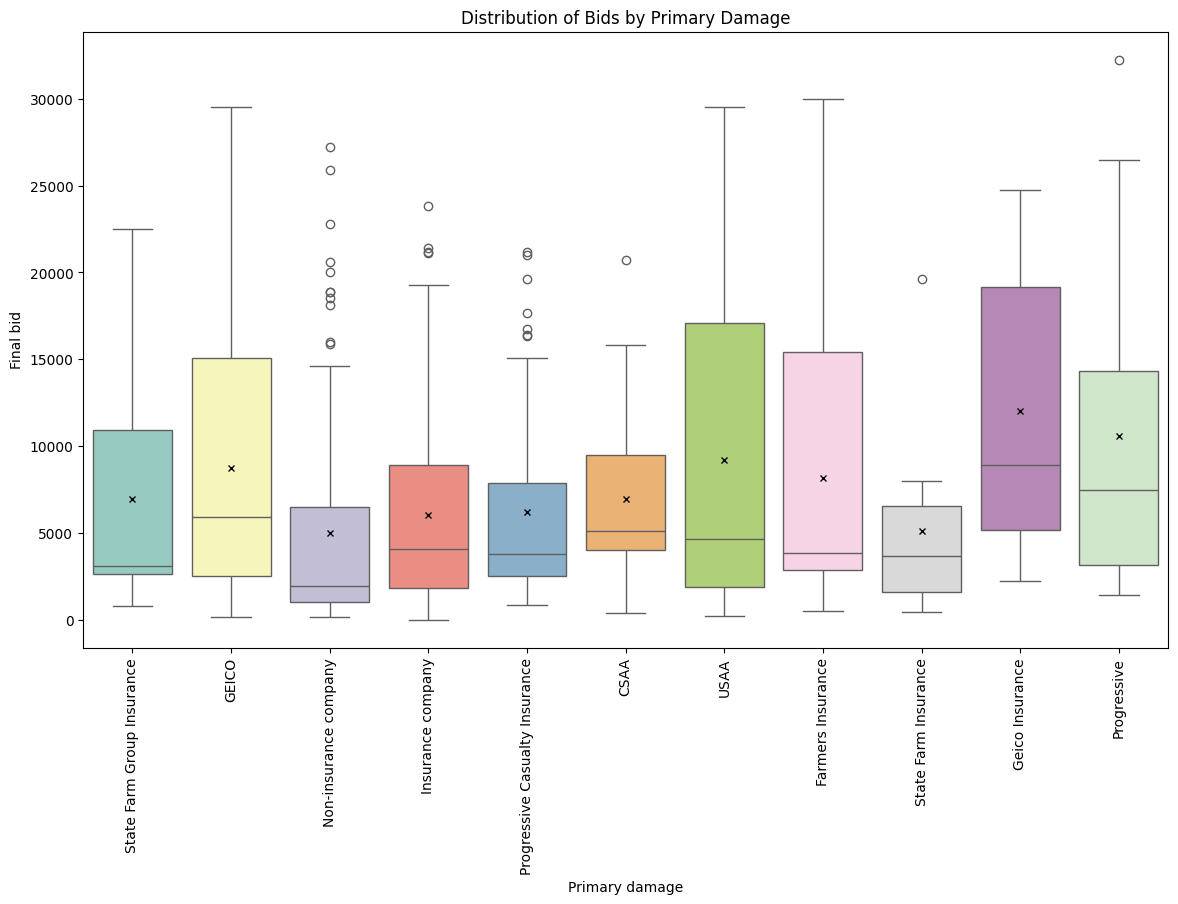

In [492]:
plt.figure(figsize=(14, 8))

box = sns.boxplot(
    data=sdf,
    x='Seller',
    y='Final_bid',
    palette='Set3',
    showmeans=True,
    meanprops={"marker":"x", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}
)


plt.title('Distribution of Bids by Primary Damage', fontsize=12)
plt.xlabel('Primary damage', fontsize=10)
plt.ylabel('Final bid', fontsize=10)
plt.xticks(rotation=90)
# plt.grid(True)

plt.show()

**Conclusion:** taking aside sellers with very few lots, there seem to be no difference among major insurance companies.
However, 'State Farm Insurance" sells cars cheaper than everyone else. Interesting

## Distribution by Manufacturing Year

In [493]:
year_df = df.groupby('Year', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

year_df = year_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

year_df

,Year,Avg_final_bid,Count,Avg_actual_cash_value
22,2022,"14,064.95",44,"31,644.68"
20,2020,"8,687.91",33,"23,704.48"
12,2012,"2,960.94",32,"10,359.69"
19,2019,"10,523.44",32,"26,102.59"
23,2023,"19,578.91",32,"37,883.00"
21,2021,"13,632.81",32,"30,581.22"
14,2014,"4,102.03",29,"12,080.55"
17,2017,"5,314.93",28,"16,833.93"
16,2016,"5,819.44",27,"16,998.41"
10,2010,"1,933.12",25,"7,147.72"


In [494]:
hist = px.histogram(year_df,
                   x='Year',
                    y = 'Count',
                  #  color='Avg_final_bid',
                   nbins=24,
                   opacity=0.6,
                  #  barmode='overlay',
                  #  histnorm='percent',
                   marginal='box',
                    )

hist.update_layout(xaxis_title='Year',
                   yaxis_title='Count',)

hist.show()

Seem to be ± normal distribution. No surprises here

## Distribution by start code:

In [495]:
code_df = df.groupby('Start code', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

code_df = code_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

code_df

,Start code,Avg_final_bid,Count,Avg_actual_cash_value
1,Run and Drive,"7,216.09",370,"17,754.82"
2,Starts,"6,525.12",65,"19,709.28"
0,No information,"5,754.44",45,"17,531.07"
3,Stationary,"6,630.30",33,"17,957.52"


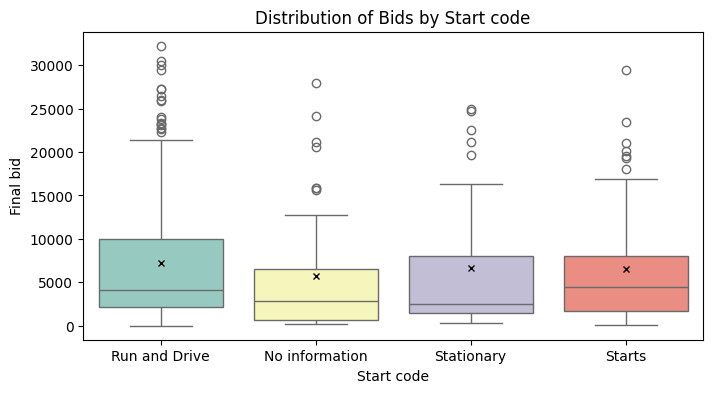

In [496]:
plt.figure(figsize=(8, 4))

box = sns.boxplot(
    data=df,
    x='Start code',
    y='Final_bid',
    palette='Set3',  # Color palette
    showmeans=True,  # Show the mean as a point
    meanprops={"marker":"x", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}  # Mean marker properties
)


plt.title('Distribution of Bids by Start code', fontsize=12)
plt.xlabel('Start code', fontsize=10)
plt.ylabel('Final bid', fontsize=10)
# plt.xticks(rotation=45)
# plt.grid(True)

plt.show()

Not much is happening here but it's clear that Stationary cars are overall cheaper than others

## Distribution by Mileage:

In [497]:
hist = px.histogram(df,
                   x='Odometer_km',
                  #  nbins=20,
                   opacity=0.6,
                  #  barmode='overlay',
                  #  histnorm='percent',

                    )

hist.update_layout(xaxis_title='Mileage',
                   yaxis_title='Count',)

hist.show()

In [498]:
sctr = px.scatter(df, x = 'Odometer_km', y = "Final_bid", title = "Actual cash value vs bid price", hover_name = df.index)

sctr.update_layout(xaxis_title = "Mileage", yaxis_title= "Final bid")

sctr.show()

Nothing unexpected here. Higher mileage = lower bid

## Distribution by Engine size

In [499]:
box = px.box(df,
             y='Final_bid',
             x='Eng_L',
             points='all',
             title='Dependency between Engine L and Final bid?')

box.show()

In [500]:
box = px.box(df,
             y='Eng_L',
            #  size = 1,
            #  x='Eng_L',
             points='all',
             title='Distribution of Engine L')

# box.update_layout(yaxis=dict(type='log'))

box.show()

There's clearly a difference in price for cars with different engine size. However there's a lot of missing data in this column so it's not very reliable for making predicitons

## Missing keys and Manual transmission

In [501]:
print(f"Missing key: {(df[df['Key'] != 'Present']).shape[0]} cars")
print(f"Manual transmission: {(df[df['Transmission'] == 'Manual']).shape[0]} cars")

Missing key: 14 cars
Manual transmission: 11 cars


In [502]:
box = px.box(df,
             y='Final_bid',
             x='Key',
             points='all',
             title='Dependency between Missing key and Final bid?')

box.show()

In [503]:
box = px.box(df,
             y='Final_bid',
             x='Transmission',
             points='all',
             title='Dependency between Transmission and Final bid?')

box.show()

There's very few lots with missing keys. According to available data, cars with missing keys are more expensive. That just doesn't make sense so we'll not be using this column for predictions until more data is available.

Manual is overall cheaper. Evrth makes sense.

## Sale status

In [504]:
status_df = df.groupby('Sale Status', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

status_df = status_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

status_df

,Sale Status,Avg_final_bid,Count,Avg_actual_cash_value
1,On minimum bid,"7,296.60",187,"18,788.16"
2,Pure sale,"6,972.08",138,"18,439.41"
0,On approval,"8,928.75",20,"26,959.00"


In [505]:
box = px.box(df,
             y='Final_bid',
             x='Sale Status',
             points='all',
             title='Dependency between Sale Status and Final bid?')

box.show()

There's clearly a difference between these categories. Will use this data for predictions

## Categorical data visualization

In [506]:
burst_df = df.groupby(by=['Model', 'Primary damage', 'Secondary damage','Start code'], as_index=False).agg({'Final_bid': pd.Series.count})


burst_df = burst_df.rename(columns = {'Final_bid' : 'Count'})
burst_df = burst_df.sort_values('Count', ascending=False)



burst = px.sunburst(burst_df,
                    path=['Model', 'Primary damage', 'Start code', 'Secondary damage'],
                    values='Count',
                    title='Interactive visualisation of categorical data',
                   )

burst.show()

If scrapping is done for all bids without any filtering, there's a huge proportion of Camry, Corolla and Prius. Rav4 amount is also reasonable. However other models have less than 25% of share combined.

For more accurate predictions it makes sense to collect more data exclusively for those models

# **Final thoughts about correlations**

Parameters interesting for price prediction:
Categorical:
* Model
* Primary damage
* Secondary damage
* Start code
* Transmission
* Sale status

Numerical:
* Year
* Odometer
* Actual cash value
* Estimated repair cost (a lot of zero values affects prediction)


Will not be used for predictions:
* Series (a lot of missing data / not systematic)
* Key (not enough data to make sense of it)
* Cylinders (a lot of missing data)
* Engine size, L (a lot of missing data)
* Engine HP (a lot of missing data)

### Pairplot charts:

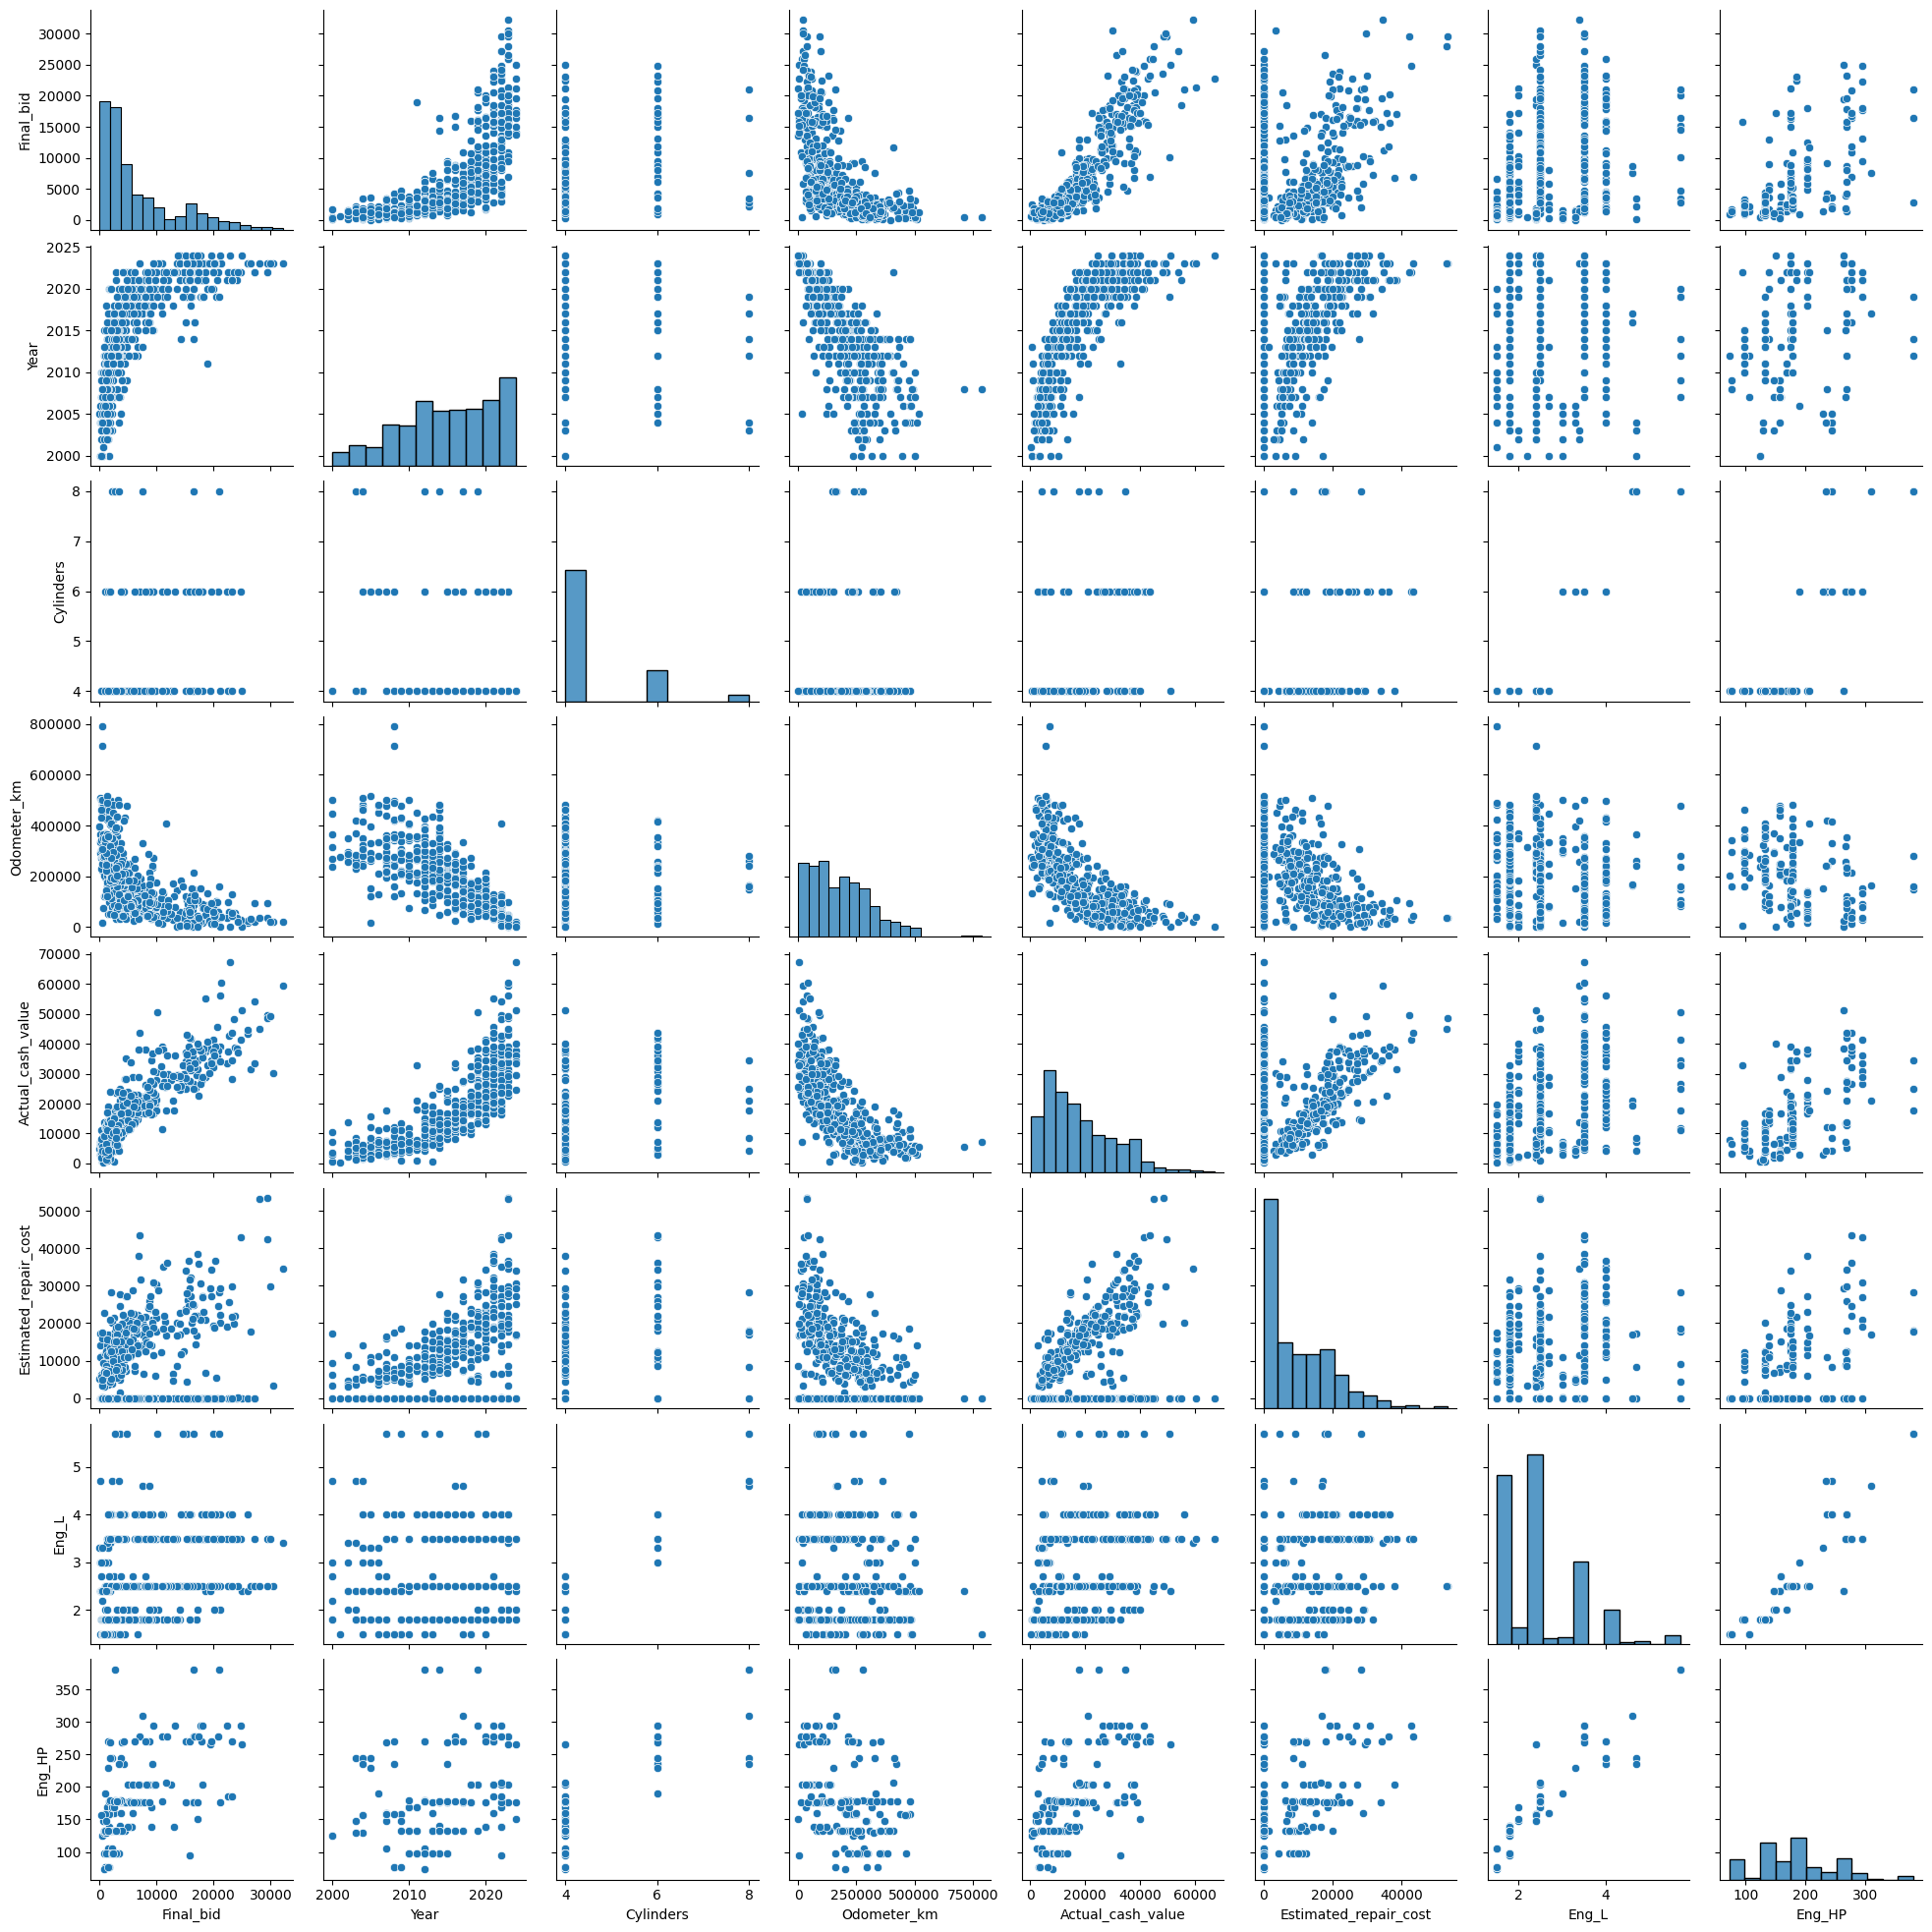

In [507]:

# sns.pairplot(df, hue='Final_bid')
sns.pairplot(df)

# **Auction price prediction**

In [508]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = df[['Year', 'Primary damage', 'Secondary damage', 'Start code', 'Key', 'Model',  'Transmission', 'Odometer_km', 'Actual_cash_value', 'Estimated_repair_cost', 'Sale Status' ]]  # 'Eng_L', 'Eng_HP',
y = df['Final_bid']

categorical = ['Primary damage', 'Secondary damage', 'Start code', 'Model', 'Transmission', 'Sale Status']
numerical = ['Year', 'Odometer_km', 'Actual_cash_value', 'Estimated_repair_cost']  # , 'Eng_L', 'Eng_HP'

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ])

model = RandomForestRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Odometer_km',
                                                   'Actual_cash_value',
                                                   'Estimated_repair_cost']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Primary damage',
                                                   'Secondary damage',
                                                   'Start code', 'Model',
                                                   'Transmission',
                                                   'Sale Status'])])),
                ('model', RandomForestRegressor(random_state=42))])

Make a prediction

In [509]:
def predict_price(car_details):
    input_df = pd.DataFrame([car_details])
    prediction = pipeline.predict(input_df)
    return prediction[0]


to_be_predicted = {'Year': 2021,
                   'Primary damage': 'Front end',
                   'Secondary damage': '',
                   'Start code': 'Run and Drive',  # stationary increases price??  >> need more data
                   'Model': 'Corolla',
                   'Transmission': 'Automatic',
                   'Odometer_km': 100930,  # higher mileage increases price?? o_0  >> need more data
                   'Actual_cash_value': 35817,
                   'Estimated_repair_cost': 19817,
                   'Sale Status': 'Pure sale',
                   }

predicted_price = predict_price(to_be_predicted)
print(f'Predicted Price: ${predicted_price}')

Predicted Price: $17711.5


# Final thoughts and todo's:
* Check how model performs for each model separately
* Compare results if zero's are removed from Estimated Repair Cost
* Scrap more data for better accuracy =)


**Limitations:**
* Seasonal trends, correlation with political events, etc. are not taken in account
* Seeing the trend that 4 models dominate heavily, further scrapping was done selectively filtering by lot price. Thus the dataset do not represent the natural distribution of the models and prices anymore. Instead it's tuned to make predictions for rare/expensive models more accurate
